In [1]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile 

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
# Facebook Prophet quick-start guide: https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [3]:
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [4]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [5]:
# For testing: print URL of desired variable, paste into browser, and open downloaded data file
#pm25['url']
#pm10['url']
#wspd['url']
#rhum['url']
temp['url']

'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/D14/Met/TEMP//horario_000.ic&from=031215&to=220126&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

In [6]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Non-ideal way of dealing with column numbers in PM data vs. weather data
    data = [ line+' ,' for line in data ]
    # Keep lines with date; time; and validated, preliminary, or non-validated data (latter two are only in PM datasets)
    data = [ line.split(',')[0:5] for line in data if \
             isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) or isfloat(line.split(',')[4]) ]
    return data

In [7]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

# Scrape and format data, and produce final pandas dataframe
for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary', 'non-validated'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    # Combine validated, preliminary, and non-validated data columns
    df[series['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
    df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [8]:
# Strip out ds (datestamp) and pm2.5 (for the y column) for the Prophet prediction
df_prophet = df_tot[['datetime','pm2.5']]
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'pm2.5':'y'})

In [9]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

In [10]:
df_tot.tail()

,pm2.5,pm10,rhum,temp,wspd,wdir
datetime,,,,,,
2022-01-26 05:00:00,8.0,34.0,88.0004,12.4667,0.350949,157.515
2022-01-26 06:00:00,7.0,47.0,87.8333,12.9833,0.280312,127.888
2022-01-26 07:00:00,18.0,74.0,75.2500,16.1333,1.054300,145.269
2022-01-26 08:00:00,17.0,70.0,67.4167,17.7833,1.311760,133.173
2022-01-26 09:00:00,NaN,NaN,57.8333,20.6833,0.747970,115.628


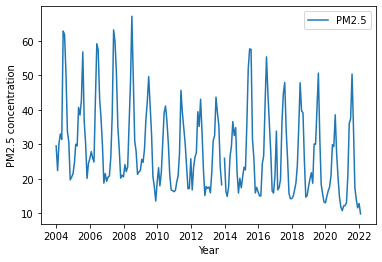

In [11]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
t_min='2000-01-01'
t_max='2030-01-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('M').mean(),'-', label='PM2.5')
#plt.plot(df_tot['pm10'][t_min:t_max].resample('M').mean(),'-', label='PM10')
#plt.plot(df_tot['temp'][t_min:t_max].resample('M').mean(),'-', label='humidity')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration')
plt.legend()

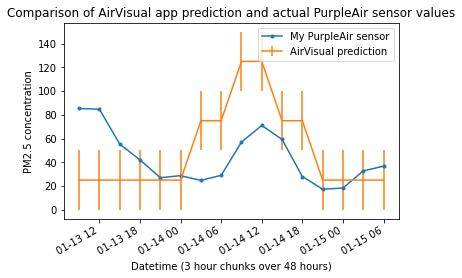

The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.


In [12]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period

airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start='2022-01-13 09:00:00', end='2022-01-15 06:00:00', periods=16)

fig, ax = plt.subplots()
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
#ax.plot(dates,sensor, 'b.')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction')
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('PM2.5 concentration')
ax.legend()
plt.show()

print('The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.')

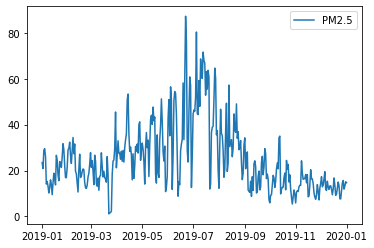

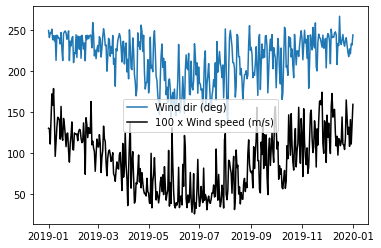

In [13]:
# Sample plots
# Top: resampled (daily) PM2.5 concentration as a function of time in 2019 (pre-pandemic year)
# Bottom: resampled (daily) wind direction (deg) and wind speed (m/s, rescaled by 100x) with the same time range
##### THERE ARE CLEAR CORRELATIONS BETWEEN PM2.5 CONCENTRATION AND BOTH WIND DIRECTION AND WIND SPEED.  
##### IN THE WINTER THE WIND DIES DOWN, AND THUS THE POLLUTION IS NOT BLOWN AWAY.
##### THE CHANGE IN WIND DIRECTION FROM THE WEST=270 DEG IN THE SUMMER VS. THE SOUTH=180 DEG IN THE WINTER
#####    DESERVES FURTHER EXPLORATION.

t_min='2019-01-01'
t_max='2020-01-01'
plt.figure()
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('D').mean(),'-', label='PM2.5')
plt.legend()
plt.figure()
plt.plot(df_tot['wdir'][t_min:t_max].resample('D').mean(),'-', label='Wind dir (deg)')
plt.plot(100*df_tot['wspd'][t_min:t_max].resample('D').mean(),'k-', label='100 x Wind speed (m/s)')
plt.legend()

In [15]:
# Perform a simple prediction of Santiago's AQI using Prophet
# Prophet requires a df (named 'df') with columns named 'ds' (datestamp) and 'y' (numeric measurement to be forecast)
df = df_prophet
df.tail()

,ds,y
158254,2022-01-26 05:00:00,8.0
158255,2022-01-26 06:00:00,7.0
158256,2022-01-26 07:00:00,18.0
158257,2022-01-26 08:00:00,17.0
158258,2022-01-26 09:00:00,NaN


In [16]:
# Instantiate model and fit data (takes 2-3 min)
m = Prophet()
m.fit(df)

Initial log joint probability = -72.2825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        524297    0.00272359         93496      0.2688      0.2688      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        524502   0.000574979       15585.9     0.09609           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        524618    0.00424453       3822.94           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        524703    0.00050614       2597.64           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        524765   0.000937499       11534.7           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

|dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        525127    0.00121163       15133.5           1           1     1366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        525135   0.000759684       9532.89           1           1     1475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        525152    0.00301472       14044.4      0.3228           1     1591   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499        525162   0.000534935       4552.42           1           1     1702   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599        525170   2.04544e-05       310.387      0.2591           1     1819   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [17]:
# Make future df
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
158619,2023-01-22 09:00:00
158620,2023-01-23 09:00:00
158621,2023-01-24 09:00:00
158622,2023-01-25 09:00:00
158623,2023-01-26 09:00:00


In [18]:
# Make forecast (takes 1 minute)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
158619,2023-01-22 09:00:00,18.705902,-7.437089,44.399331
158620,2023-01-23 09:00:00,17.648637,-7.156485,43.731010
158621,2023-01-24 09:00:00,20.374025,-6.408304,47.702254
158622,2023-01-25 09:00:00,20.523718,-7.345650,49.071328
158623,2023-01-26 09:00:00,21.369652,-6.286807,46.819913


In [19]:
##### These interactive plotly plots seem to make the notebook crash

# Interactive plotly plot of prediction
# plot_plotly(m, forecast)

# For plotting interactive plot of components
# plot_components_plotly(m, forecast)

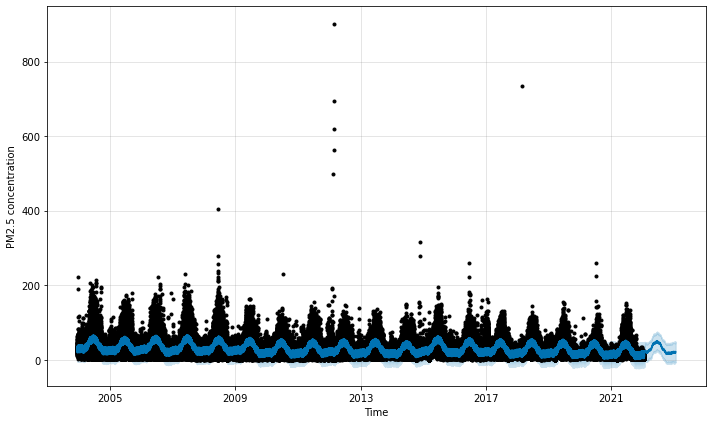

In [27]:
# Static plot of forecast
fig1 = m.plot(forecast, xlabel='Time', ylabel='PM2.5 concentration')

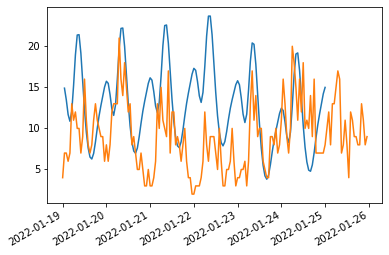

In [57]:
t_min = '2022-1-19'
t_max = '2022-1-25'
# From model
dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
# Actual data
values = df_tot['pm2.5'][t_min:t_max]


fig, ax = plt.subplots()
ax.plot(dates_model,values_model, '-')
ax.plot(values, '-')
fig.autofmt_xdate()


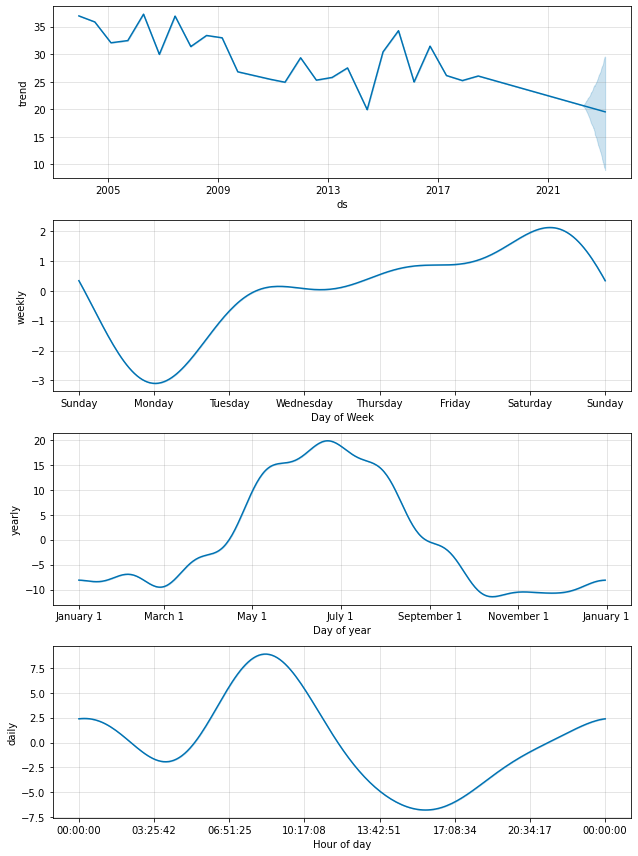

In [21]:
# Static plot of components
fig2 = m.plot_components(forecast)

In [14]:
# TO DO: 
# Use the Prophet model to predict part of the existing Santiago data and calculate RMSE
# Do PCA on the time series and remove the annual and diurnal signals (can I pull out the BBQs from the downstairs neighbors?)
# Go beyond the Prophet model and include all of the Santiago data (PM2.5, PM10, temp, humidity, wind speed, wind dir) vs. just some of it (e.g., removing wspd and wdir) to see which variables provide better predictive power.
